#  Report to Management for Apprentice Chef
By Sarah Medina

# Analysis

Today we will be looking at insights based on Revenue (Regression modeling) and Cross Sell Success (Classification Modeling) that have potential to drive growth and success for Apprentice Chef. 

While analyzing revenue, I found that the best result accounted for 77.7% of variance (R Squared) when using the full OLS model (Appendix 2). When compared to revenue, Median Meal rating, Average prep video time, and total meals ordered were most highly correlated (Appendix 1) and represent opportunistic funnels in pushing for revenue increase. The company should focus on creating meals that are consistently popular among their customers matched with videos that are intuitively enjoyable. Encouraging clients to buy more meals could come from Apprentice Chef’s system, creating tailored suggestions based on a customers previous actions such as remembering  previously ordered meals, highest rated meals or offering  recommended dishes. 

When looking at Cross Sell Promotion, the full Gbm model (Appendix 3)  gave the best result, with an AUC of .734 and least amount of false negatives (Appendix 5). The features of most importance (Appendix 4) were Cancellations before noon, Early Deliveries, and Number of Names. Demographic or personal information should be looked into to find more insight about the customer. This was done by creating the number of names variable which helped differentiate one customer  (i.e. "Aegon") from another to look at who opted in to the cross selling promotion as well as prevent mass grouping of client stigmas. 

What I observed is that timely customers who pay attention to detail are more likely to commit. The company must be prompt in their actions (deliver on time) as well as the client (cancel on time) and in doing so this will help promote cross selling. Cross selling promotion success will come if Chef Apprentice  continues to value each unique customer and be punctual in their actions.


In [1]:
#importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.linear_model # linear models

#sklearn and train test split
from sklearn.model_selection import train_test_split # train/test split
#regressions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix          # confusion matrix
from sklearn.metrics import roc_auc_score             # auc 
#Knn Neighbors
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression
from sklearn.neighbors import KNeighborsClassifier    # KNN classification
from sklearn.preprocessing import StandardScaler # standard scaler

#import randomlibraries
import random as rand  #rand
import gender_guesser.detector as gender #gender guesser

# CART model packages
from sklearn.tree import DecisionTreeClassifier       # classification trees
from sklearn.tree import export_graphviz              # exports graphviz
from six import StringIO                              # saves objects in memory
from IPython.display import Image                     # displays on frontend
import pydotplus                                      # interprets dot objects

#Packages for Classification Tree Modelling
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer                 # c scorer
from sklearn.ensemble import RandomForestClassifier     # random for
from sklearn.ensemble import GradientBoostingClassifier # gbm

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# specifying file name
file = 'Apprentice_Chef_Dataset.xlsx'

# reading the file into Python
chefset = pd.read_excel(io = file)


#pd set option to see all the column names 
pd.set_option('display.max_columns', None)
chefset.head()


,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205


# User Defined Functions

In [2]:
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='NUM_OF_NAMES'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [3]:
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df



In [4]:
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [5]:
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800, export = False):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    export     : bool, defalut False
        whether or not to export the tree as a .png file
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width,
                unconfined = True)


    return img

In [6]:
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')

# Primary Feature Engineering

In [7]:
#working with emails (categoricals) first
#we want to seperate email domains before making dummie vars

# setting random seed
rand.seed(a = 327)

# STEP 1: splitting personal emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chefset.iterrows():
    
    # splitting email domain at '@'
    split_email = chefset.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


# displaying the results
email_df

,0,1
0,saathos,unitedhealth.com
1,alysanne.osgrey,ge.org
2,edwyd.fossoway,jnj.com
3,eleyna.westerling,ge.org
4,elyn.norridge,jnj.com
...,...,...
1941,obara.sand,yahoo.com
1942,quentyn.blackwood,yahoo.com
1943,rhonda.rowan,gmail.com
1944,turnip,yahoo.com


In [8]:
# STEP 2: concatenating with original DataFrame

# safety measure in case of multiple concatenations
chefset = pd.read_excel(file)


# renaming column to concatenate
email_df.columns = ['0' , 'EMAIL_domains']


# concatenating personal_email_domain with friends DataFrame
chefset = pd.concat([chefset, email_df['EMAIL_domains']],
                     axis = 1)


# printing value counts of personal_email_domain
chefset.loc[: ,'EMAIL_domains'].value_counts()

gmail.com           303
protonmail.com      284
yahoo.com           274
msn.com              72
aol.com              69
passport.com         64
hotmail.com          63
live.com             62
me.com               59
amex.com             30
mcdonalds.com        28
jnj.com              28
cocacola.com         28
merck.com            28
apple.com            27
nike.com             27
dupont.com           26
ge.org               26
ibm.com              26
microsoft.com        25
chevron.com          25
exxon.com            24
travelers.com        24
unitedhealth.com     24
boeing.com           23
pg.com               22
verizon.com          22
mmm.com              22
caterpillar.com      22
disney.com           21
walmart.com          21
visa.com             20
pfizer.com           20
jpmorgan.com         19
unitedtech.com       18
goldmansacs.com      18
cisco.com            18
intel.com            17
homedepot.com        17
Name: EMAIL_domains, dtype: int64

In [9]:
#STEP 3: splittling the domains at "."
# email domain types
# creating a list for email names with no dots to rduce error
dot_lst = []

# looping over each email address
for index, col in chefset.iterrows():
    
    # splitting email domain at '.'
    email_dot = chefset.loc[index, 'EMAIL_domains'].split(sep = '.')
    
    # appending dot_lst with the results
    dot_lst.append(email_dot)
    

# converting _df into a DataFrame 
emailclean_df = pd.DataFrame(dot_lst)


# displaying the results
emailclean_df

,0,1
0,unitedhealth,com
1,ge,org
2,jnj,com
3,ge,org
4,jnj,com
...,...,...
1941,yahoo,com
1942,yahoo,com
1943,gmail,com
1944,yahoo,com


In [10]:
# STEP 4 : CLEAN EMAIL DOMAINS IN A NEW COLUMN IN CHEFSET

# safety measure in case of multiple concatenations
chefset = pd.read_excel(file)


# renaming column to concatenate
emailclean_df.columns = ['CLEAN_EMAILS' , '1']


# concatenating personal_email_domain with chefset DataFrame
#adds the column to the dataset
chefset = pd.concat([chefset, emailclean_df['CLEAN_EMAILS']],
                   axis = 1)


# printing value counts of personal_email_domain
chefset.loc[: ,'CLEAN_EMAILS'].value_counts()

gmail           303
protonmail      284
yahoo           274
msn              72
aol              69
passport         64
hotmail          63
live             62
me               59
amex             30
mcdonalds        28
jnj              28
merck            28
cocacola         28
nike             27
apple            27
ibm              26
ge               26
dupont           26
microsoft        25
chevron          25
unitedhealth     24
travelers        24
exxon            24
boeing           23
mmm              22
verizon          22
caterpillar      22
pg               22
disney           21
walmart          21
visa             20
pfizer           20
jpmorgan         19
goldmansacs      18
cisco            18
unitedtech       18
intel            17
homedepot        17
Name: CLEAN_EMAILS, dtype: int64

In [11]:
#Aggregating personal and work emails into 2 groups 
#values for some emails are less than 100 observations so we aggregate

# email domain types, personal and work
personal_emails = ['gmail','protonmail','yahoo']

work_emails  = ['amex','cocacola','jnj','merck',
                       'mcdonalds','nike','apple','dupont','ibm',
                       'ge','microsoft','chevron','travelers',
                       'exxon','unitedhealth','boeing','caterpillar',
                       'mmm','pg','verizon','walmart','disney',
                       'pfizer','visa','jpmorgan','unitedtech',
                       'cisco','goldmansacs','intel','homedepot']

junk_emails= ['me','aol','hotmail','live','msn','passport']

# placeholder list
email_lst = []


# looping to group observations by domain type
for domain in chefset['CLEAN_EMAILS']:
    
        if domain in personal_emails:
            email_lst.append('personal')
            
        elif domain in work_emails:
            email_lst.append('work')
        
        elif domain in junk_emails:
            email_lst.append('junk')
            
        else:
            print('Unknown')


# concatenating with original DataFrame
chefset['DOMAIN_GROUP'] = pd.Series(email_lst)


# checking results
chefset['DOMAIN_GROUP'].value_counts()

personal    861
work        696
junk        389
Name: DOMAIN_GROUP, dtype: int64

In [12]:
# one hot encoding categorical variables
one_hot_DOMAIN_GROUP    = pd.get_dummies(chefset['DOMAIN_GROUP'])

# dropping categorical variables after they've been encoded
chefset= chefset.drop('DOMAIN_GROUP', axis = 1)

# joining codings together
#appending new categorical data
chefset = chefset.join([one_hot_DOMAIN_GROUP ])

# saving new columns
new_columns = chefset.columns

In [13]:
#missing value analysis and imputation
#initiatiating an imputation value for family name
fill= "na"

#imputing 'FAMILY_NAME'
chefset['FAMILY_NAME'] =chefset['FAMILY_NAME'].fillna(fill)

In [14]:
#checking to see if any values are still missing
chefset.isnull().any(axis=0).any(axis=0)

False

In [15]:
#changing the name of a column
#largest order size is actually the avg number or meals ordered
chefset.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_NUM_MEALS_ORD'}, inplace=True)

In [16]:
# calling text_split_feature for number of names
text_split_feature('NAME', chefset, sep='')


# checking results
chefset['NUM_OF_NAMES']

0       1
1       2
2       2
3       2
4       2
       ..
1941    2
1942    2
1943    2
1944    1
1945    2
Name: NUM_OF_NAMES, Length: 1946, dtype: int64

# Regression Analysis 

In [17]:
#building a model for the regression ANalysis
chefset_reg= chefset.copy()

In [18]:
#log transforming Revenue and saving it to the dataset
chefset_reg['log_REVENUE'] = np.log10(chefset_reg['REVENUE'])

In [19]:
# dummy variables for vars with zeros.
chefset_reg['has_viewed_photos']        = 0
chefset_reg['has_MASTER_CLASSES_ATTENDED']        = 0
chefset_reg['has_MOBILE_LOGINS']        = 0
chefset_reg['has_WEEKLY_PLAN']        = 0
chefset_reg['has_EARLY_DELIVERIES']        = 0
chefset_reg['has_LATE_DELIVERIES']        = 0
chefset_reg['has_CANCELLATIONS_BEFORE_NOON']        = 0
chefset_reg['has_CANCELLATIONS_AFTER_NOON']        = 0


#if we're above a threshold, creating a new column 
# iterating over each original column to
# change values in the new feature columns
for index, value in chefset_reg.iterrows():
    
    #total photos viewed
    if chefset_reg.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        chefset_reg.loc[index, 'has_viewed_photos'] = 1
    
    #master claases
    if chefset_reg.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        chefset_reg.loc[index, 'has_MASTER_CLASSES_ATTENDED'] = 1
    #mobile logins    
    if chefset_reg.loc[index, 'MOBILE_LOGINS'] > 0:
        chefset_reg.loc[index, 'has_MOBILE_LOGINS'] = 1
    #weekly plan
    if chefset_reg.loc[index, 'WEEKLY_PLAN'] > 0:
        chefset_reg.loc[index, 'has_WEEKLY_PLAN'] = 1
    #early deliveries
    if chefset_reg.loc[index, 'EARLY_DELIVERIES'] > 0:
        chefset_reg.loc[index, 'has_EARLY_DELIVERIES'] = 1
    #late deliveries
    if chefset_reg.loc[index, 'LATE_DELIVERIES'] > 0:
        chefset_reg.loc[index, 'has_LATE_DELIVERIES'] = 1
    #cancel before 12
    if chefset_reg.loc[index, 'CANCELLATIONS_BEFORE_NOON'] > 0:
        chefset_reg.loc[index, 'has_CANCELLATIONS_BEFORE_NOON'] = 1
    #after 12
    if chefset_reg.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 0:
        chefset_reg.loc[index, 'has_CANCELLATIONS_AFTER_NOON'] = 1

# checking results
chefset_reg[['has_viewed_photos', 'has_MASTER_CLASSES_ATTENDED','has_MOBILE_LOGINS',
         'has_WEEKLY_PLAN', 'has_EARLY_DELIVERIES', 'has_LATE_DELIVERIES', 
         'has_CANCELLATIONS_BEFORE_NOON', 'has_CANCELLATIONS_AFTER_NOON']].head()

,has_viewed_photos,has_MASTER_CLASSES_ATTENDED,has_MOBILE_LOGINS,has_WEEKLY_PLAN,has_EARLY_DELIVERIES,has_LATE_DELIVERIES,has_CANCELLATIONS_BEFORE_NOON,has_CANCELLATIONS_AFTER_NOON
0,0,0,1,0,0,1,1,1
1,1,0,1,1,0,1,0,0
2,0,0,1,1,0,1,1,0
3,0,0,1,1,0,1,1,0
4,1,1,1,1,0,1,0,0


In [20]:
#Log transform interval and count data, saving this new variable to chefset
#creating new log vriables
chefset_reg['log_UNIQUE_MEALS_PURCH'] = np.log10(chefset_reg['UNIQUE_MEALS_PURCH'])
chefset_reg['log_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(chefset_reg['CONTACTS_W_CUSTOMER_SERVICE'])
chefset_reg['log_PRODUCT_CATEGORIES_VIEWED'] = np.log10(chefset_reg['PRODUCT_CATEGORIES_VIEWED'])
chefset_reg['log_PC_LOGINS'] = np.log10(chefset_reg['PC_LOGINS'])
chefset_reg['log_MEDIAN_MEAL_RATING'] = np.log10(chefset_reg['MEDIAN_MEAL_RATING'])
chefset_reg['log_AVG_CLICKS_PER_VISIT'] = np.log10(chefset_reg['AVG_CLICKS_PER_VISIT'])
chefset_reg['log_AVG_NUM_MEALS_ORD'] = np.log10(chefset_reg['AVG_NUM_MEALS_ORD'])
chefset_reg['log_TOTAL_MEALS_ORDERED'] = np.log10(chefset_reg['TOTAL_MEALS_ORDERED'])


log_corr = chefset_reg.loc[ : , ['UNIQUE_MEALS_PURCH','log_UNIQUE_MEALS_PURCH','CONTACTS_W_CUSTOMER_SERVICE',
                             'log_CONTACTS_W_CUSTOMER_SERVICE',
                             'PRODUCT_CATEGORIES_VIEWED','log_PRODUCT_CATEGORIES_VIEWED',
                             'PC_LOGINS','log_PC_LOGINS','MEDIAN_MEAL_RATING',
                             'log_MEDIAN_MEAL_RATING','AVG_CLICKS_PER_VISIT','log_AVG_CLICKS_PER_VISIT'
                             ,'AVG_NUM_MEALS_ORD','log_AVG_NUM_MEALS_ORD','TOTAL_MEALS_ORDERED',
                             'REVENUE',
                             'log_REVENUE']  ].corr(method = 'pearson')\
                                                 .round(decimals = 2)


#looking at the variables/ log vars to see how correlated they are to revenue and log_rev
log_corr.loc[ ['UNIQUE_MEALS_PURCH','log_UNIQUE_MEALS_PURCH','CONTACTS_W_CUSTOMER_SERVICE',
                             'log_CONTACTS_W_CUSTOMER_SERVICE',
                             'PRODUCT_CATEGORIES_VIEWED','log_PRODUCT_CATEGORIES_VIEWED',
                             'PC_LOGINS','log_PC_LOGINS','MEDIAN_MEAL_RATING',
                             'log_MEDIAN_MEAL_RATING','AVG_CLICKS_PER_VISIT','log_AVG_CLICKS_PER_VISIT',
                             'AVG_NUM_MEALS_ORD','log_AVG_NUM_MEALS_ORD','TOTAL_MEALS_ORDERED'],
              ['REVENUE', 'log_REVENUE']   ]

,REVENUE,log_REVENUE
UNIQUE_MEALS_PURCH,-0.06,-0.08
log_UNIQUE_MEALS_PURCH,-0.12,-0.13
CONTACTS_W_CUSTOMER_SERVICE,0.10,-0.04
log_CONTACTS_W_CUSTOMER_SERVICE,0.17,0.05
PRODUCT_CATEGORIES_VIEWED,0.03,0.04
log_PRODUCT_CATEGORIES_VIEWED,0.01,0.01
PC_LOGINS,0.02,0.01
log_PC_LOGINS,0.01,0.01
MEDIAN_MEAL_RATING,0.61,0.65
log_MEDIAN_MEAL_RATING,0.55,0.61


In [21]:
# creating a (Pearson) correlation matrix
df_corr = chefset_reg.corr().round(2)

#which vars are highly correlated?
# printing (Pearson) correlations with revenue
print(df_corr.loc['REVENUE'].sort_values(ascending = False))

REVENUE                            1.00
log_REVENUE                        0.95
AVG_PREP_VID_TIME                  0.64
MEDIAN_MEAL_RATING                 0.61
log_TOTAL_MEALS_ORDERED            0.61
TOTAL_MEALS_ORDERED                0.60
log_MEDIAN_MEAL_RATING             0.55
TOTAL_PHOTOS_VIEWED                0.47
MASTER_CLASSES_ATTENDED            0.45
has_MASTER_CLASSES_ATTENDED        0.45
AVG_NUM_MEALS_ORD                  0.44
log_AVG_NUM_MEALS_ORD              0.42
has_viewed_photos                  0.37
log_CONTACTS_W_CUSTOMER_SERVICE    0.17
AVG_TIME_PER_SITE_VISIT            0.14
CONTACTS_W_CUSTOMER_SERVICE        0.10
NUM_OF_NAMES                       0.04
PRODUCT_CATEGORIES_VIEWED          0.03
MOBILE_NUMBER                      0.03
has_CANCELLATIONS_BEFORE_NOON      0.02
PC_LOGINS                          0.02
CANCELLATIONS_BEFORE_NOON          0.01
TASTES_AND_PREFERENCES             0.01
WEEKLY_PLAN                        0.01
log_PRODUCT_CATEGORIES_VIEWED      0.01


# Appendix 1

Text(0.5, 1.0, 'Matrix for Top Correlated Variables')

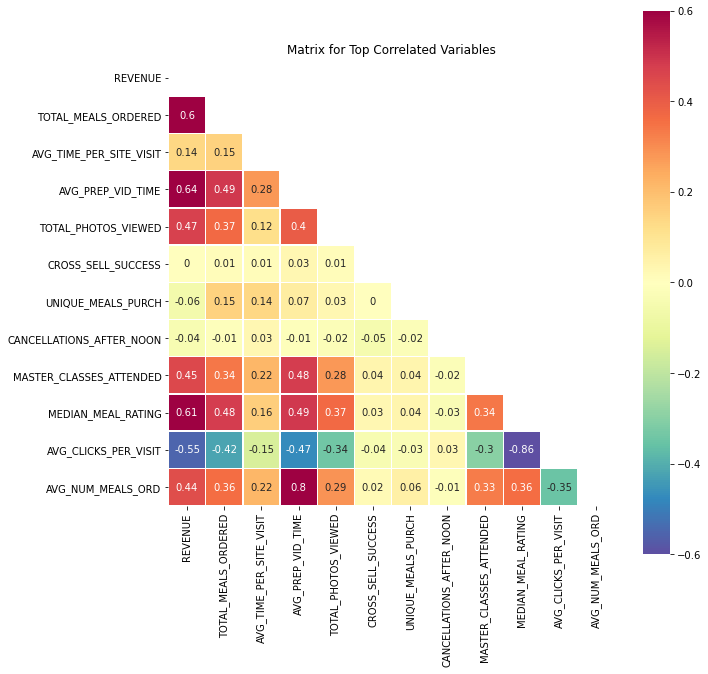

In [22]:
#Creating a correlation matrix for the most highly correlated variables
# limiting the size of the correlation matrix
df_corr2 = df_corr.loc[ ['REVENUE','TOTAL_MEALS_ORDERED','AVG_TIME_PER_SITE_VISIT',
                         'AVG_PREP_VID_TIME','TOTAL_PHOTOS_VIEWED','CROSS_SELL_SUCCESS',
                         'UNIQUE_MEALS_PURCH',
                         'CANCELLATIONS_AFTER_NOON',
                         'MASTER_CLASSES_ATTENDED',
                         'MEDIAN_MEAL_RATING','AVG_CLICKS_PER_VISIT','AVG_NUM_MEALS_ORD'],
                        ['REVENUE','TOTAL_MEALS_ORDERED','AVG_TIME_PER_SITE_VISIT',
                         'AVG_PREP_VID_TIME','TOTAL_PHOTOS_VIEWED','CROSS_SELL_SUCCESS',
                         'UNIQUE_MEALS_PURCH',
                         'CANCELLATIONS_AFTER_NOON',
                         'MASTER_CLASSES_ATTENDED',
                         'MEDIAN_MEAL_RATING','AVG_CLICKS_PER_VISIT','AVG_NUM_MEALS_ORD']]

fig, ax = plt.subplots(figsize=(10,10))
#corrs = chefset_reg.corr()
mask = np.zeros_like(df_corr2)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_corr2, cmap='Spectral_r', mask=mask, square=True, annot = True, 
            vmin=-.6, vmax=.6,linewidths = 0.5)
plt.title('Matrix for Top Correlated Variables')

In [23]:
#Building Full Model to Compare  Explanatory Variables 

############################################

# dropping from the explanatory variable set
chefset_reg_data = chefset_reg.drop(['REVENUE','log_REVENUE',
                                          #following columns removed due to no use or
                                          #redundancy (ie: email categories and all email names)
                                          'NAME','EMAIL','FIRST_NAME','FAMILY_NAME','CLEAN_EMAILS'
                                          
                                         ], axis = 1)

# preparing response variables for log_chef_target
log_chef_target = chefset_reg.loc[ : , 'log_REVENUE']

# formatting each explanatory variable for statsmodels
for val in chefset_reg_data:
    print(val,'+')


CROSS_SELL_SUCCESS +
TOTAL_MEALS_ORDERED +
UNIQUE_MEALS_PURCH +
CONTACTS_W_CUSTOMER_SERVICE +
PRODUCT_CATEGORIES_VIEWED +
AVG_TIME_PER_SITE_VISIT +
MOBILE_NUMBER +
CANCELLATIONS_BEFORE_NOON +
CANCELLATIONS_AFTER_NOON +
TASTES_AND_PREFERENCES +
PC_LOGINS +
MOBILE_LOGINS +
WEEKLY_PLAN +
EARLY_DELIVERIES +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
AVG_PREP_VID_TIME +
AVG_NUM_MEALS_ORD +
MASTER_CLASSES_ATTENDED +
MEDIAN_MEAL_RATING +
AVG_CLICKS_PER_VISIT +
TOTAL_PHOTOS_VIEWED +
junk +
personal +
work +
NUM_OF_NAMES +
has_viewed_photos +
has_MASTER_CLASSES_ATTENDED +
has_MOBILE_LOGINS +
has_WEEKLY_PLAN +
has_EARLY_DELIVERIES +
has_LATE_DELIVERIES +
has_CANCELLATIONS_BEFORE_NOON +
has_CANCELLATIONS_AFTER_NOON +
log_UNIQUE_MEALS_PURCH +
log_CONTACTS_W_CUSTOMER_SERVICE +
log_PRODUCT_CATEGORIES_VIEWED +
log_PC_LOGINS +
log_MEDIAN_MEAL_RATING +
log_AVG_CLICKS_PER_VISIT +
log_AVG_NUM_MEALS_ORD +
log_TOTAL_MEALS_ORDERED +


In [24]:
#building a full model using OLS Regression
lm_full = smf.ols(formula = """log_REVENUE ~
CROSS_SELL_SUCCESS +
TOTAL_MEALS_ORDERED +
UNIQUE_MEALS_PURCH +
PRODUCT_CATEGORIES_VIEWED +
AVG_PREP_VID_TIME +
AVG_NUM_MEALS_ORD +
MEDIAN_MEAL_RATING +
TOTAL_PHOTOS_VIEWED +
personal +
work +
junk+
has_viewed_photos +
log_UNIQUE_MEALS_PURCH +
log_CONTACTS_W_CUSTOMER_SERVICE +
log_PRODUCT_CATEGORIES_VIEWED +
log_MEDIAN_MEAL_RATING +
log_AVG_NUM_MEALS_ORD +
has_WEEKLY_PLAN +
has_MASTER_CLASSES_ATTENDED +
log_TOTAL_MEALS_ORDERED """,
                               data = chefset_reg)


# telling Python to run the data through the blueprint
results_full = lm_full.fit()


# printing the results
results_full.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_REVENUE   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     347.3
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:55:52   Log-Likelihood:                 1707.0
No. Observations:                1946   AIC:                            -3374.
Df Residuals:                    1926   BIC:                            -3263.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.6235      0.029     55.722      0.000       1.566       1.681
CROSS_SELL_SUCCESS                 -0.0143      0.005     -2.768      0.006      -0.024      -0.004
TOTAL_MEALS_ORDERED                -0.0009      0.000     -8.446      0.000      -0.001      -0.001
UNIQUE_MEALS_PURCH                  0.0534      0.003     18.786      0.000       0.048       0.059
PRODUCT_CATEGORIES_VIEWED           0.0093      0.003      3.542      0.000       0.004       0.014
AVG_PREP_VID_TIME                   0.0015   9.32e-05     16.388      0.000       0.001       0.002
AVG_NUM_MEALS_ORD                  -0.0358      0.006     -5.876      0.000      -0.048      -0.024
MEDIAN_MEAL_RATING                  0.1360      0.014      9.411      0.000       0.108       0.164
TOTAL_PHOTOS_VIEWED              5.836e-05   1.92e-05      3.041      0.002    2.07e-05     9.6e-05
personal                            0.5431      0.010     53.696      0.000       0.523       0.563
work                                0.5416      0.010     52.289      0.000       0.521       0.562
junk                                0.5388      0.011     51.157      0.000       0.518       0.559
has_viewed_photos                   0.0201      0.007      2.954      0.003       0.007       0.033
log_UNIQUE_MEALS_PURCH             -0.6220      0.026    -23.992      0.000      -0.673      -0.571
log_CONTACTS_W_CUSTOMER_SERVICE     0.1728      0.019      9.069      0.000       0.135       0.210
log_PRODUCT_CATEGORIES_VIEWED      -0.0870      0.026     -3.335      0.001      -0.138      -0.036
log_MEDIAN_MEAL_RATING             -0.4150      0.076     -5.436      0.000      -0.565      -0.265
log_AVG_NUM_MEALS_ORD               0.2117      0.054      3.906      0.000       0.105       0.318
has_WEEKLY_PLAN                    -0.0117      0.005     -2.165      0.031      -0.022      -0.001
has_MASTER_CLASSES_ATTENDED         0.0360      0.005      6.637      0.000       0.025       0.047
log_TOTAL_MEALS_ORDERED             0.4194      0.021     20.072      0.000       0.378       0.460
==============================================================================
Omnibus:                      475.753   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3574.305
Skew:                          -0.941   Prob(JB):                         0.00
Kurtosis:                       9.367   Cond. No.                     1.19e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.46e-29. This might indicate that there are
strong multicollinearity probl

In [25]:
# declaring set of x-variables
x_variables = ['CROSS_SELL_SUCCESS','TOTAL_MEALS_ORDERED','UNIQUE_MEALS_PURCH',
            'PRODUCT_CATEGORIES_VIEWED','AVG_PREP_VID_TIME','AVG_NUM_MEALS_ORD',
            'MEDIAN_MEAL_RATING', 'TOTAL_PHOTOS_VIEWED','personal', 'work',
            'has_viewed_photos', 'log_UNIQUE_MEALS_PURCH','log_CONTACTS_W_CUSTOMER_SERVICE',
            'log_PRODUCT_CATEGORIES_VIEWED','log_MEDIAN_MEAL_RATING','log_AVG_NUM_MEALS_ORD',
            'has_WEEKLY_PLAN','has_MASTER_CLASSES_ATTENDED','log_TOTAL_MEALS_ORDERED']

# looping to make x-variables suitable for statsmodels
for val in x_variables:
    print(f"{val} +")

CROSS_SELL_SUCCESS +
TOTAL_MEALS_ORDERED +
UNIQUE_MEALS_PURCH +
PRODUCT_CATEGORIES_VIEWED +
AVG_PREP_VID_TIME +
AVG_NUM_MEALS_ORD +
MEDIAN_MEAL_RATING +
TOTAL_PHOTOS_VIEWED +
personal +
work +
has_viewed_photos +
log_UNIQUE_MEALS_PURCH +
log_CONTACTS_W_CUSTOMER_SERVICE +
log_PRODUCT_CATEGORIES_VIEWED +
log_MEDIAN_MEAL_RATING +
log_AVG_NUM_MEALS_ORD +
has_WEEKLY_PLAN +
has_MASTER_CLASSES_ATTENDED +
log_TOTAL_MEALS_ORDERED +


In [26]:
#build a train test split for each dataset
# applying modelin scikit-learn

# preparing x-variables from the OLS model
ols_data = chefset_reg.loc[:,x_variables]


# preparing response variable log_chef_target
log_chef_target = chefset_reg.loc[:,'log_REVENUE']




###############################################
## setting up more than one train-test split ##
###############################################
# FULL X-dataset (normal Y)
x_train_FULL, x_test_FULL, y_train_FULL, y_test_FULL = train_test_split(
            chefset_reg_data,     # x-variables
            log_chef_target,   # y-variable
            test_size = 0.25,
            random_state = 219)

#Looking at a smaller variable set
# OLS p-value x-dataset (normal Y)
x_train_OLS, x_test_OLS, y_train_OLS, y_test_OLS = train_test_split(
            ols_data,         # x-variables
            log_chef_target,   # y-variable
            test_size = 0.25,
            random_state = 219)

# Appendix 2- OLS Model

In [27]:
#Creating an OLS Model for the Full Dataset
# INSTANTIATING a model object
#calling linear regression
lr = LinearRegression()


# FITTING to the training data to that model object
lr_fit = lr.fit(x_train_FULL, y_train_FULL)


# PREDICTING on new data
lr_pred = lr_fit.predict(x_test_FULL)


# SCORING the results
print('Full OLS Training Score :', lr.score(x_train_FULL, y_train_FULL).round(4))  # using R-square
print('Full OLS Testing Score  :',  lr.score(x_test_FULL, y_test_FULL).round(4)) # using R-square

lr_train_score= lr.score(x_train_FULL, y_train_FULL).round(4)
lr_test_score=lr.score(x_train_FULL, y_train_FULL).round(4)

# displaying and saving the gap between training and testing
print('Full OLS Train-Test Gap :', abs(lr_train_score - lr_test_score).round(4))
lr_test_gap = abs(lr_train_score - lr_test_score).round(4)



Full OLS Training Score : 0.777
Full OLS Testing Score  : 0.7689
Full OLS Train-Test Gap : 0.0


In [28]:
#Naming all the variables in thsi dataset
all_variables= ['CROSS_SELL_SUCCESS','TOTAL_MEALS_ORDERED','UNIQUE_MEALS_PURCH','CONTACTS_W_CUSTOMER_SERVICE',
            'PRODUCT_CATEGORIES_VIEWED','AVG_TIME_PER_SITE_VISIT','MOBILE_NUMBER','AVG_PREP_VID_TIME',
            'AVG_NUM_MEALS_ORD','CANCELLATIONS_BEFORE_NOON','CANCELLATIONS_AFTER_NOON',
            'MEDIAN_MEAL_RATING', 'TOTAL_PHOTOS_VIEWED','personal', 'work','TASTES_AND_PREFERENCES',
              'PC_LOGINS','MOBILE_LOGINS','WEEKLY_PLAN','EARLY_DELIVERIES','LATE_DELIVERIES','PACKAGE_LOCKER',
             'REFRIGERATED_LOCKER', 'MASTER_CLASSES_ATTENDED','AVG_CLICKS_PER_VISIT','TOTAL_PHOTOS_VIEWED', 
                'junk','NUM_OF_NAMES', 'has_MOBILE_LOGINS','has_EARLY_DELIVERIES','has_LATE_DELIVERIES',
                'has_CANCELLATIONS_AFTER_NOON','log_UNIQUE_MEALS_PURCH','has_viewed_photos', 
                'log_UNIQUE_MEALS_PURCH','log_CONTACTS_W_CUSTOMER_SERVICE','log_PC_LOGINS',
             'log_AVG_CLICKS_PER_VISIT',   'log_PRODUCT_CATEGORIES_VIEWED','log_MEDIAN_MEAL_RATING',
            'log_AVG_NUM_MEALS_ORD','has_WEEKLY_PLAN','has_MASTER_CLASSES_ATTENDED','log_TOTAL_MEALS_ORDERED']





In [29]:
# zipping each feature name to its coefficient
lr_model_values = zip(chefset_reg_data[x_variables].columns,
                      lr_fit.coef_.round(decimals = 2))


# setting up a placeholder list to store model features
lr_model_lst = [('intercept', lr_fit.intercept_.round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in lr_model_values:
    lr_model_lst.append(val)
    

# checking the results
for pair in lr_model_lst:
    print(pair)

('intercept', 2.46)
('CROSS_SELL_SUCCESS', -0.02)
('TOTAL_MEALS_ORDERED', -0.0)
('UNIQUE_MEALS_PURCH', 0.05)
('PRODUCT_CATEGORIES_VIEWED', -0.0)
('AVG_PREP_VID_TIME', 0.01)
('AVG_NUM_MEALS_ORD', 0.0)
('MEDIAN_MEAL_RATING', 0.0)
('TOTAL_PHOTOS_VIEWED', 0.0)
('personal', 0.02)
('work', 0.01)
('has_viewed_photos', 0.02)
('log_UNIQUE_MEALS_PURCH', -0.01)
('log_CONTACTS_W_CUSTOMER_SERVICE', 0.0)
('log_PRODUCT_CATEGORIES_VIEWED', -0.0)
('log_MEDIAN_MEAL_RATING', -0.0)
('log_AVG_NUM_MEALS_ORD', -0.01)
('has_WEEKLY_PLAN', -0.01)
('has_MASTER_CLASSES_ATTENDED', 0.0)
('log_TOTAL_MEALS_ORDERED', -0.03)


# Classification Analysis

In classification,  I did not use as many engineered variables as I did in regression analysis.

In [30]:
#Biserial Point Correlations
# creating a (Pearson) correlation matrix
df_corr = chefset.corr(method='pearson').round(2)

# printing (Pearson) correlations with CSS
print(df_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending = False))

CROSS_SELL_SUCCESS             1.00
work                           0.19
NUM_OF_NAMES                   0.16
CANCELLATIONS_BEFORE_NOON      0.16
MOBILE_NUMBER                  0.10
TASTES_AND_PREFERENCES         0.08
REFRIGERATED_LOCKER            0.07
CONTACTS_W_CUSTOMER_SERVICE    0.04
PC_LOGINS                      0.04
PACKAGE_LOCKER                 0.04
MASTER_CLASSES_ATTENDED        0.04
personal                       0.04
AVG_PREP_VID_TIME              0.03
MEDIAN_MEAL_RATING             0.03
EARLY_DELIVERIES               0.02
AVG_NUM_MEALS_ORD              0.02
LATE_DELIVERIES                0.01
TOTAL_MEALS_ORDERED            0.01
TOTAL_PHOTOS_VIEWED            0.01
AVG_TIME_PER_SITE_VISIT        0.01
PRODUCT_CATEGORIES_VIEWED      0.00
UNIQUE_MEALS_PURCH             0.00
REVENUE                        0.00
WEEKLY_PLAN                   -0.01
AVG_CLICKS_PER_VISIT          -0.04
CANCELLATIONS_AFTER_NOON      -0.05
MOBILE_LOGINS                 -0.05
junk                        

In [31]:
#Building Full Model to Compare  Explanatory Variables 

############################################

# making a copy of chef
chefset_class_data = chefset.copy()


# dropping from the explanatory variable set
chefset_class_data = chefset_class_data.drop(['CROSS_SELL_SUCCESS',
                                          #following columns removed due to no use or
                                          #redundancy (ie: email categories and all email names)
                                          'NAME','EMAIL','FIRST_NAME','FAMILY_NAME','CLEAN_EMAILS'
                                          
                                         ], axis = 1)
# declaring response variable
chefset_target = chefset.loc[ : , 'CROSS_SELL_SUCCESS']

# formatting each explanatory variable for statsmodels
for val in chefset_class_data:
    print(val,'+')


REVENUE +
TOTAL_MEALS_ORDERED +
UNIQUE_MEALS_PURCH +
CONTACTS_W_CUSTOMER_SERVICE +
PRODUCT_CATEGORIES_VIEWED +
AVG_TIME_PER_SITE_VISIT +
MOBILE_NUMBER +
CANCELLATIONS_BEFORE_NOON +
CANCELLATIONS_AFTER_NOON +
TASTES_AND_PREFERENCES +
PC_LOGINS +
MOBILE_LOGINS +
WEEKLY_PLAN +
EARLY_DELIVERIES +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
AVG_PREP_VID_TIME +
AVG_NUM_MEALS_ORD +
MASTER_CLASSES_ATTENDED +
MEDIAN_MEAL_RATING +
AVG_CLICKS_PER_VISIT +
TOTAL_PHOTOS_VIEWED +
junk +
personal +
work +
NUM_OF_NAMES +


In [32]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            chefset_class_data,
            chefset_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chefset_target)


# merging training data for statsmodels
chefset_train = pd.concat([x_train, y_train], axis = 1)

In [33]:
#response var proportions
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")





Response Variable Proportions (Training Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



In [34]:
#creating Dictionary sets 
chef_dict={
    # full model
 'logit_full'   : ['REVENUE','TOTAL_MEALS_ORDERED','UNIQUE_MEALS_PURCH',
                   'CONTACTS_W_CUSTOMER_SERVICE','PRODUCT_CATEGORIES_VIEWED',
                   'AVG_TIME_PER_SITE_VISIT','MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
                   'CANCELLATIONS_AFTER_NOON','TASTES_AND_PREFERENCES','PC_LOGINS',
                   'MOBILE_LOGINS','WEEKLY_PLAN','EARLY_DELIVERIES','LATE_DELIVERIES',
                   'PACKAGE_LOCKER','REFRIGERATED_LOCKER','AVG_PREP_VID_TIME',
                   'AVG_NUM_MEALS_ORD','MASTER_CLASSES_ATTENDED','MEDIAN_MEAL_RATING',
                   'AVG_CLICKS_PER_VISIT','TOTAL_PHOTOS_VIEWED','junk','personal',
                   'work','NUM_OF_NAMES'],


 # significant variables only (set 1)
 'logit_sig'    : ['MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
'TASTES_AND_PREFERENCES','NUM_OF_NAMES','PC_LOGINS','EARLY_DELIVERIES','personal','junk','REFRIGERATED_LOCKER',
                  'MASTER_CLASSES_ATTENDED'],


 # significant variables only (set 2)
 'logit_sig_2'  : ['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 
                  'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'EARLY_DELIVERIES',
                  'REFRIGERATED_LOCKER', 'junk', 'work', 
                  'NUM_OF_NAMES'],
    
}

In [35]:
# instantiating a logistic regression model object
logistic = smf.logit(formula = """ CROSS_SELL_SUCCESS ~ 
                                         MOBILE_NUMBER + 
                                         CANCELLATIONS_BEFORE_NOON +  
                                         TASTES_AND_PREFERENCES + 
                                         NUM_OF_NAMES+
                                         PC_LOGINS + 
                                         EARLY_DELIVERIES + 
                                         REFRIGERATED_LOCKER + 
                                         work + 
                                         junk +MASTER_CLASSES_ATTENDED 
                                          """,
                                        data = chefset_train)


# fitting the model object
results = logistic.fit()


# checking the results SUMMARY
results.summary()

Optimization terminated successfully.
         Current function value: 0.541596
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1448
Method:                           MLE   Df Model:                           10
Date:                Thu, 28 Jan 2021   Pseudo R-squ.:                  0.1375
Time:                        20:55:52   Log-Likelihood:                -790.19
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 2.050e-48
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -3.0339      0.658     -4.608      0.000      -4.324      -1.744
MOBILE_NUMBER                 0.8741      0.176      4.955      0.000       0.528       1.220
CANCELLATIONS_BEFORE_NOON     0.2762      0.046      5.949      0.000       0.185       0.367
TASTES_AND_PREFERENCES        0.3895      0.135      2.877      0.004       0.124       0.655
NUM_OF_NAMES                  0.5491      0.094      5.864      0.000       0.366       0.733
PC_LOGINS                     0.2265      0.107      2.117      0.034       0.017       0.436
EARLY_DELIVERIES              0.0610      0.028      2.205      0.027       0.007       0.115
REFRIGERATED_LOCKER           0.5314      0.209      2.542      0.011       0.122       0.941
work                          0.6010      0.144      4.167      0.000       0.318       0.884
junk                         -1.3114      0.157     -8.344      0.000      -1.619      -1.003
MASTER_CLASSES_ATTENDED       0.2217      0.097      2.278      0.023       0.031       0.412
=============================================================================================
"""

In [36]:
#calling the explanatory vars for train test split
chefset_data_explanatory   =  chefset.loc[ : , chef_dict['logit_sig']]
chefset_target_class =  chefset.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                                chefset_data_explanatory ,
                                chefset_target_class,
                                random_state = 219,
                                test_size    = 0.25,
                                stratify     = chefset_target_class)

# merging training data for statsmodels
chefset_train = pd.concat([x_train, y_train], axis = 1)

# Appendix 3-GBM Tuned Model

In [37]:
# INSTANTIATING the model object without hyperparameters
gbm_tuned = GradientBoostingClassifier(loss          = 'exponential',
                                              learning_rate = 0.3,
                                              n_estimators  = 125,
                                              subsample= .6,
                                              criterion     = 'friedman_mse',
                                              min_impurity_decrease=0.1,
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219,
                                              min_samples_leaf=2,
                                              min_samples_split=8)

#using FIT
# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(x_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# SCORING the results
print('GBM Tuned Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('GBM Tuned Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('GBM Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                         y_score = gbm_tuned_pred).round(4))

# saving scoring data for future use
gbm_tuned_train_score = gbm_tuned.score(x_train, y_train).round(4) # accuracy
gbm_tuned_test_score  = gbm_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score,gbm_tuned_auc
gbm_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = gbm_tuned_pred).round(4) # auc

GBM Tuned Training ACCURACY: 0.8053
GBM Tuned Testing  ACCURACY: 0.7885
GBM Tuned AUC Score        : 0.7343


# Appendix 4

<ipython-input-6-47df5c06e99f>:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


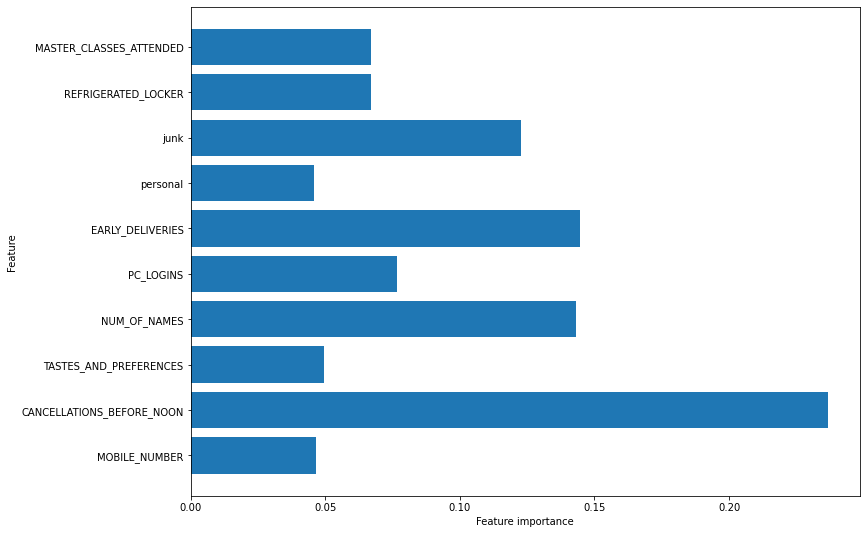

In [38]:
# plotting feature importances
plot_feature_importances(model=gbm_tuned_fit,
                        train=x_train
                         
                        )

In [39]:
# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")


True Negatives : 91
False Positives: 65
False Negatives: 38
True Positives : 293



# Appendix 5

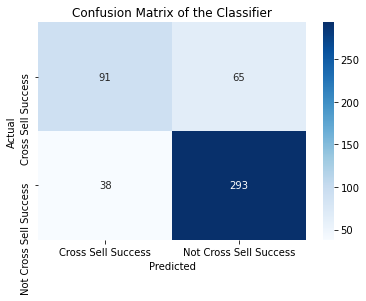

In [40]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = gbm_tuned_pred,
          labels = ['Cross Sell Success', 'Not Cross Sell Success'])